# Covid Use Case Step 1 - 3

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
from pathlib import Path

from nvita.utils import open_json
from nvita.utils import to_json
from nvita.models.data import SplittedTSData
from nvita.models.lstm import LSTM
import nvita.models.train as mt
from nvita.models.utils import save_model, load_model

D:\Programming\IDE\Anaconda\envs\hons\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
PATH_ROOT = Path(os.getcwd()).parent.absolute()
PATH_RAW = os.path.join(PATH_ROOT, "data", "raw_data")
PATH_CLEAN = os.path.join(PATH_ROOT, "data", "clean_data")

my_metadata = open_json(os.path.join(
    PATH_ROOT, "experiments", "metadata.json"))
print(my_metadata)

{'data': ['Electricity', 'NZTemp', 'CNYExch', 'Oil'], 'seeds': ['2210', '9999', '58361', '789789', '1111111'], 'y_col_name': ['Consumption', 'Auckland', 'Close', 'Close'], 'window_size': ['4', '3', '7', '7'], 'models': ['CNN', 'LSTM', 'GRU', 'RF'], 'attacks': ['NOATTACK', 'BRS', 'BRNV', 'FGSM', 'BIM', 'NVITA', 'FULLVITA'], 'n_values': [1, 3, 5], 'epsilons': [0.05, 0.1, 0.15, 0.2], 'targets': ['Positive', 'Negative']}


## Read Parameter settings

In [3]:
seed = my_metadata["seeds"][0] # Use 2210 as the seed
TEST_SIZE = 70
VALID_PER = 0.2

## Step 1: Preprocessing

In [4]:
covid_df_all = pd.read_csv(os.path.join(PATH_RAW, "owid-covid-data.csv"), sep = ",")

In [5]:
covid_df = covid_df_all[covid_df_all["location"] == "United States"]

In [6]:
covid_df.columns

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'total_tests', 'new_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations', 'new_vaccinations_smoothed',
       't

In [7]:
# Select features
col_list = ["new_cases", "new_deaths", "icu_patients", "hosp_patients", "new_tests", "new_vaccinations", "stringency_index", "population", "gdp_per_capita"]

covid_df = covid_df[col_list]

In [8]:
covid_df = covid_df.iloc[175:879, :]
covid_df["new_vaccinations"] = covid_df["new_vaccinations"].fillna(0)

In [9]:
# Make sure there is no NaN in clean df
covid_df.isnull().values.sum()

0

In [10]:
covid_df.to_csv(os.path.join(PATH_CLEAN, "CovidUSA.csv"), index = False)

In [11]:
covid_df.shape

(704, 9)

### Save Splitted data

In [12]:
path_df = os.path.join(PATH_ROOT, "data", "clean_data", "CovidUSA" +".csv")

s_data = SplittedTSData(path_df, "CovidUSA", "new_cases", 7, int(seed))
s_data.train_valid_test_split(TEST_SIZE, VALID_PER)
s_data.save_splitted_data(PATH_ROOT)

## Step 2 hyperparameter tuning

In [13]:
def grid_search_rnn(s_d, model_name = "LSTM"):
    max_epochs = [100, 250, 500]
    learning_rate = [0.001, 0.005, 0.01]
    #module__window_size = window_size
    input_dim = s_d.X_train.shape[2]
    module__hidden_dim = [64, 128, 256]
    module__num_layers = [1, 2, 4]
    output_dim = s_d.y_train.shape[1]

    best_score = np.Inf
    best_rnn_paras = []
    for epoch in max_epochs:
        for lr in learning_rate: 
            for hidden_dim in module__hidden_dim:
                for num_layers in module__num_layers:
                    if model_name == "LSTM":
                        model = LSTM(input_dim, hidden_dim, num_layers, output_dim)
                    elif model_name == "GRU":
                        model = GRU(input_dim, hidden_dim, num_layers, output_dim)
                    mt.train(model, lr, epoch, s_d.X_train, s_d.y_train)
                    score = np.mean(mt.evaluate(model, s_d.X_valid, s_d.y_valid)**2)
                    if score < best_score:
                        # Smaller score MSE indicates better performance
                        best_score = score
                        best_rnn_paras = [epoch, lr, input_dim, hidden_dim, num_layers, output_dim]
    print("Best Score for " + model_name + " is " + str(best_score) + " on dataset " + str(s_d.df_name))
    return best_rnn_paras


### Load the Splitted Data from disk

In [14]:
s_data = SplittedTSData()
s_data = s_data.load_splitted_data(PATH_ROOT, "CovidUSA", seed)

In [15]:
best_lstm_paras_dict = dict()
best_lstm_paras_dict["CovidUSA"] = grid_search_rnn(s_data, "LSTM")

Best Score for LSTM is 0.00046636592 on dataset CovidUSA


In [17]:
to_json(best_lstm_paras_dict , os.path.join(
    PATH_ROOT, "experiments", "COVIDUSA_paras.json"))

## Step 3 train model (LSTM)

In [18]:
model_paras = open_json(os.path.join(
    PATH_ROOT, "experiments", "COVIDUSA_paras.json"))
print(model_paras)

{'CovidUSA': [500, 0.01, 9, 64, 4, 1]}


In [23]:
epoch, lr, input_dim, hidden_dim, num_layers, output_dim = model_paras[s_data.df_name]
model = LSTM(input_dim, hidden_dim, num_layers, output_dim)
losses = mt.train(model, lr, epoch, s_data.X_train, s_data.y_train)

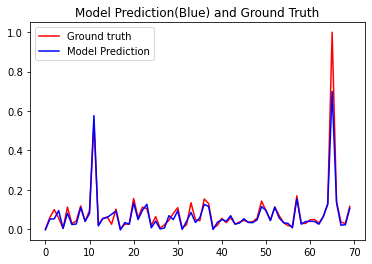

In [26]:
# Visulaize the model prediction
plt.plot(s_data.y_test, color = "Red", label="Ground truth")
plt.plot(mt.predict(model, s_data.X_test).detach().numpy(), color = "Blue", label="Model Prediction")
plt.title("Model Prediction(Blue) and Ground Truth")
plt.legend()
plt.show()

In [27]:
score = np.mean(mt.evaluate(model, s_data.X_test, s_data.y_test)**2)
save_model(model, PATH_ROOT, s_data.df_name, s_data.seed)